# Importante: antes de executar esse notebook execute o mortalidade.ipynb para gerar os dados de mortalidade

# Projeto de Ciência de dados:
## Desenvolvimento de um indíce de vulnerabilidade das cidades brasileiras em relação ao covid- 19

## OBSERVAÇÃO: Caso esteja no linux, tire o encoding = "ISO-8859-1" do lado das leituras dos datasets.

### Importando as bibliotecas a serem utilizadas
O primeiro passo será importar as bibliotecas a serem utilizadas

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as py
import seaborn as sb

# LOF Algorithm
from sklearn.neighbors import LocalOutlierFactor

## Normalização dos dados
from sklearn.preprocessing import MaxAbsScaler

## K-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Lendo o primeiro dataset: Dados do Covid-19

Primeiro dataset a ser lido é o dos dados sobre o COVID-19 (casos, mortes...)
Após realizar a leitura dele, utilizando o encoding "ISO-8859-1" devido aos caracteres e formato dos dados,
realizamos a redução do dataset, mantendo apenas as colunas que são relavantes para a análise.

In [2]:
df_covid = pd.read_csv('dataset-covid19.csv', encoding = "ISO-8859-1")
df_covid = df_covid[['state', 'city', 'place_type', 'city_ibge_code', 'estimated_population', 'last_available_death_rate', 'last_available_deaths']]

### Filtrando apenas para dados referentes a cidades

Nessa parte, filtramos para armazenar apenas os dados que fazem referência a cidades (tenham seu place_type igual a city).
Após isso, realizamos a contagem para ver quantos dados nulos temos no dataset resultante


In [3]:
df_covid = df_covid[df_covid.place_type == 'city'] ## Filtra para pegar apenas dados de cidades
df_covid.isnull().sum() ## Realiza a contagem de quantos valores nulos temos

state                         0
city                          0
place_type                    0
city_ibge_code               19
estimated_population         19
last_available_death_rate     0
last_available_deaths         0
dtype: int64

### Ajustes do Dataset

Ao observarmos quais dados estão faltantes, observamos que o city desses casos apresentam valores iguais a Importados/Indefinidos. Portanto, retiramos do dataset esses dados.

Após, realizamos a conversão da coluna city_ibge_code, para que em vez de ser do tipo string, seja do tipo inteiro.

Por fim, renomeamos o nome de duas colunas, para facilitar o uso posterior: De state para UF, e de city para Nome do município.

In [4]:
df_covid = df_covid[df_covid.city != 'Importados/Indefinidos'] ## Remoção das linhas em branco

df_covid['city_ibge_code'] = df_covid['city_ibge_code'].astype(int) ## Conversão da coluna para inteiro

df_covid= df_covid.rename(columns={'state': 'UF'}) ## Trocando o nome de state para UF
df_covid= df_covid.rename(columns={'city': 'Nome do município'}) ## Trocando o nome de city para Nome do município
df_covid

,UF,Nome do município,place_type,city_ibge_code,estimated_population,last_available_death_rate,last_available_deaths
12,PA,Abaetetuba,city,1500107,159080.0,0.0283,119
13,PA,Abel Figueiredo,city,1500131,7486.0,0.0049,2
14,PA,Acará,city,1500206,55669.0,0.0184,16
15,PA,Afuá,city,1500305,39567.0,0.0045,11
16,PA,Água Azul do Norte,city,1500347,27615.0,0.0000,0
...,...,...,...,...,...,...,...
5610,RO,Theobroma,city,1101609,10395.0,0.0084,1
5611,RO,Urupá,city,1101708,11272.0,0.0123,3
5612,RO,Vale do Anari,city,1101757,11377.0,0.0059,1
5613,RO,Vale do Paraíso,city,1101807,6656.0,0.0176,4


### Lendo o segundo Dataset: Dados de internações
O segundo dataset é sobre os dados de internações nas unidades hospitalares. Novamente usamos o enconding ISO-8859-1.

Após, retiramos as linhas que contem dados faltantes e renomamos duas colunas (estadoSigla para UF, e municipio para Nome do município).

Por fim, criamos uma nova coluna que é a soma da UF com o Nome do munícipio. Essa coluna será utilizada para a agragação posterior dos dados de uma mesma cidade.

In [5]:
df_inter = pd.read_csv('dataset-inter.csv',  encoding = "ISO-8859-1") ## Lê o dataset

df_inter = df_inter.dropna() ## Remove os dados nulos

df_inter= df_inter.rename(columns={'estadoSigla': 'UF'}) ## Renomeia a coluna estadoSigla para UF
df_inter= df_inter.rename(columns={'municipio': 'Nome do município'}) ## Renomeia a coluna municipio para Nome do município

df_inter['UF-City'] = df_inter['UF'] + df_inter['Nome do município']  ##Cria uma nova coluna para diferencias cada cidade
df_inter.head(95)

,estado,UF,Nome do município,cnes,nomeCnes,dataNotificacaoOcupacao,ofertaRespiradores,ofertaHospCli,ofertaHospUti,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada,UF-City
0,Amazonas,AM,Humaitá,2017016,HOSPITAL DR LUIZA DA CONCEICAO FERNANDES,2020-11-26T04:00:11.195Z,1.0,46.0,0.0,0.0,0.0,0.0,0.0,5.0,0,2.0,0,True,True,AMHumaitá
1,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27T03:00:19.869Z,0.0,54.0,0.0,18.0,0.0,6.0,0.0,4.0,0,0.0,0,True,True,PESertânia
2,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26T03:00:19.985Z,0.0,80.0,0.0,89.0,31.0,0.0,0.0,3.0,0,0.0,0,True,True,PAMarabá
4,Espírito Santo,ES,São José do Calçado,2547317,HOSPITAL SAO JOSE,2020-10-18T03:00:12.938Z,6.0,66.0,10.0,0.0,0.0,26.0,8.0,0.0,0,0.0,0,True,True,ESSão José do Calçado
7,Bahia,BA,Rio de Contas,2509636,HOSPITAL DE RIO DE CONTAS,2020-08-10T03:00:27.587Z,0.0,17.0,0.0,0.0,0.0,2.0,0.0,0.0,0,0.0,0,True,True,BARio de Contas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Paraná,PR,Corbélia,0105724,HOSPITAL DE CAMPANHA ECLEIA WOLF,2020-05-26T03:00:00.000Z,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0,True,True,PRCorbélia
96,Bahia,BA,Salvador,0003859,HOSPITAL GERAL ROBERTO SANTOS,2020-05-29T15:08:11.579Z,80.0,725.0,112.0,0.0,0.0,137.0,76.0,7.0,14,0.0,1,True,True,BASalvador
97,Bahia,BA,Salvador,0004979,HOSPITAL EVANGELICO DA BAHIA HEB,2020-05-13T17:06:40.149Z,0.0,64.0,5.0,0.0,0.0,36.0,8.0,0.0,0,0.0,1,True,True,BASalvador
98,Sergipe,SE,Aracaju,0002232,HOSPITAL SANTA IZABEL,2020-07-09T13:10:59.170Z,42.0,143.0,17.0,15.0,2.0,100.0,37.0,9.0,4,0.0,0,True,True,SEAracaju


### Tratamento dos dados de intenação

Como uma cidade pode ter muitos hospitais, optamos por agrupar todos os dados que se referem a uma mesma cidade.
Para tal, utilizamos um groupby usando a coluna criada anteriormente (UF-city), somando todos os dados.

Criamos duas novas colunas, que se referem as taxas de ocupação dos leitos disponíveis para a SRAG, tanto uti como cli.
Como a oferta pode ser zero, a divisão resultaria em infinito. Para corrigir isso, substituimos todos os valores que foram
infinito (positivo ou negativo) por 0.

In [6]:
## Realiza o groupby para unificar os dados de uma mesma cidade
df_inter = df_inter.groupby([df_inter['UF-City'], df_inter['UF'], df_inter['Nome do município']]).sum()
df_inter = df_inter.reset_index()

## Cria as duas novas colunas da taxa de ocupação
df_inter["taxa ocupado SRAG uti"] = df_inter["ocupSRAGUti"] / df_inter["ofertaSRAGUti"]
df_inter["taxa ocupado SRAG cli"] = df_inter["ocupSRAGCli"] / df_inter["ofertaSRAGCli"]


df_pop_estimada = df_covid[['UF', 'Nome do município', 'estimated_population']]
df_inter = pd.merge(df_inter,df_pop_estimada, on=["Nome do município", "UF"])


## Devemos normalizar a ocupação do hospital pela quantidade ocupada

df_inter['ocupHospCli'] = df_inter['ocupHospCli'] / df_inter['ofertaHospCli'] 
df_inter['ocupHospUti'] = df_inter['ocupHospUti'] / df_inter['ofertaHospUti'] 
df_inter['ocupSRAGCli'] = df_inter['ocupSRAGCli'] / df_inter['ofertaSRAGCli'] 
df_inter['ocupSRAGUti'] = df_inter['ocupSRAGUti'] / df_inter['ofertaSRAGUti'] 


## Devemos normalizar o número de respitadores e vagas ofertadas pela popualação da cidade

df_inter['ofertaRespiradores'] = df_inter['ofertaRespiradores'] / df_inter['estimated_population']
df_inter['ofertaHospCli'] = df_inter['ofertaHospCli'] / df_inter['estimated_population'] 
df_inter['ofertaHospUti'] = df_inter['ofertaHospUti'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGCli'] = df_inter['ofertaSRAGCli'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGUti'] = df_inter['ofertaSRAGUti'] / df_inter['estimated_population'] 




##Identifica os extremos (infinitos) e substitui por 0
df_inter[df_inter==np.inf]  = np.nan
df_inter[df_inter== -np.inf] = np.nan
df_inter["taxa ocupado SRAG uti"].fillna(0, inplace=True)
df_inter["taxa ocupado SRAG cli"].fillna(0, inplace=True)

df_inter["ocupHospCli"].fillna(0, inplace=True)
df_inter["ocupHospUti"].fillna(0, inplace=True)
df_inter["ocupSRAGCli"].fillna(0, inplace=True)
df_inter["ocupSRAGUti"].fillna(0, inplace=True)


df_inter


,UF-City,UF,Nome do município,ofertaRespiradores,ofertaHospCli,ofertaHospUti,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada,taxa ocupado SRAG uti,taxa ocupado SRAG cli,estimated_population
0,ACAcrelândia,AC,Acrelândia,0.000000,0.001033,0.000000,0.000258,0.000000,0.000000,0.000000,0.750000,0.0000,0.0,0,1.0,1.0,0.0000,0.750000,15490.0
1,ACAssis Brasil,AC,Assis Brasil,0.000000,0.001593,0.000000,0.000265,0.000000,0.000000,0.000000,0.500000,0.0000,60.0,8,1.0,1.0,0.0000,0.500000,7534.0
2,ACCruzeiro do Sul,AC,Cruzeiro do Sul,0.000067,0.001504,0.000090,0.000483,0.000112,0.447761,0.375000,0.465116,0.5000,2.0,2,2.0,2.0,0.5000,0.465116,89072.0
3,ACRio Branco,AC,Rio Branco,0.000155,0.001120,0.000058,0.000370,0.000097,0.377970,0.708333,0.732026,0.9750,14.0,5,4.0,4.0,0.9750,0.732026,413418.0
4,ALArapiraca,AL,Arapiraca,0.000150,0.001334,0.000099,0.000442,0.000137,0.225080,1.173913,0.359223,0.4375,3.0,1,3.0,3.0,0.4375,0.359223,233047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,TOPalmas,TO,Palmas,0.000313,0.002896,0.000225,0.000082,0.000065,0.633596,1.681159,0.800000,1.7000,1.0,0,9.0,9.0,1.7000,0.800000,306296.0
1952,TOParaíso do Tocantins,TO,Paraíso do Tocantins,0.000096,0.001715,0.000000,0.000674,0.000000,0.292135,0.000000,0.057143,0.0000,1.0,0,1.0,1.0,0.0000,0.057143,51891.0
1953,TOPedro Afonso,TO,Pedro Afonso,0.000000,0.002323,0.000000,0.000581,0.000000,0.156250,0.000000,0.000000,0.0000,0.0,0,1.0,1.0,0.0000,0.000000,13773.0
1954,TOPorto Nacional,TO,Porto Nacional,0.000094,0.002832,0.000000,0.000356,0.000000,0.483444,0.000000,0.052632,0.0000,2.0,0,2.0,2.0,0.0000,0.052632,53316.0


In [7]:
df_inter["ocupSRAGUti"].corr(df_inter["ocupHospUti"])

0.5089868295302992

In [8]:
df_inter["ocupSRAGUti"].corr(df_inter["ocupHospUti"])

0.5089868295302992

### Reduzindo a dimensionalidade 

Por se tratarem de muitos dados relevantes correspondentes aos hospitais, buscamos diminuir a dimensionalidade deles.
Para tal, será utilizado a técnica de PCA.

Utilizou-se com base para a construção o tutorial disponível em: https://leandrocl2005.github.io/pca_na_mao_e_no_python/

Dividimos em duas partes, pois iremos realizar dois PCA's. 
O primeiro será referente aos dados das ofertas (de vagas e de respiradores)

In [9]:
# Define a matriz X, com os dados a serem utilizados
X = df_inter[['ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti', 'ofertaSRAGCli', 'ofertaSRAGUti']]
cidades = [['UF-City','UF', 'Nome do município']]

# Calcula a média por coluna de X
mean_vec = np.mean(X, axis=0)

# Subtrai a média da respectiva coluna de X
M = X - mean_vec

# Calcula a matriz de covariância
C = M.T.dot(M) / (X.shape[0]-1)

# Determina os auto-valores e auto-vetores
autovalores, autovetores = np.linalg.eig(C)

# Ordena em ordem descrecente
pares_de_autos = [
    (
        np.abs(autovalores[i]),
        autovetores[:,i]
    ) for i in range(len(autovalores))
]
pares_de_autos.sort()
pares_de_autos.reverse()

# Calcula a variância explicada e a variância explicada cumulativa
total = sum(autovalores)
var_exp = [
    (i / total)*100 for i in sorted(
        autovalores, reverse=True
    )
]
cum_var_exp = np.cumsum(var_exp)

Após os cálculos, visualizamos as informaçoes geradas

In [10]:
x = [
    'PC %s' %i for i in range(
        1,len(autovalores)+1
    )
]
df_temp = pd.DataFrame(
    {'auto-valores': autovalores,
     'cum_var_exp':cum_var_exp,
     'var_exp':var_exp,
     'Componente':x}
)
## Dessa maneira, podemos ver os auto-valores, e o impacto na variança de cada componente
print(df_temp)
print()
print("Auto-vetores")
for autovetor in [p[1] for p in pares_de_autos]:
    print(autovetor)
print()

   auto-valores  cum_var_exp    var_exp Componente
0  4.092970e-06    92.161946  92.161946       PC 1
1  2.984309e-07    98.881753   6.719806       PC 2
2  3.543421e-08    99.679629   0.797877       PC 3
3  6.340246e-09    99.857236   0.177607       PC 4
4  7.887621e-09   100.000000   0.142764       PC 5

Auto-vetores
[-0.01810731 -0.99820937 -0.00418868 -0.05683414 -0.00158662]
[-0.03370007  0.05753015 -0.0306637  -0.99603091 -0.05036609]
[-0.76075842  0.0130762  -0.52199147  0.06180571 -0.38050047]
[-0.45618889  0.0084826   0.01336866 -0.0294535   0.88925447]
[-0.46008125  0.00503959  0.85228421  0.00220085 -0.24881042]



Observa-se com uma componente, já obtem-se praticamente toda a variança. Então será utilizada somente essa componente

In [11]:
n_componentes = 1 # projetamos apenas a primeira componente
autovetores = [p[1] for p in pares_de_autos]
A = autovetores[0:n_componentes] 
X = np.dot(X,np.array(A).T)
new_df = pd.DataFrame(X, columns=['pc1'])
new_df['UF'] = df_inter['UF']
new_df['Nome do município'] = df_inter['Nome do município']
ordered_values = new_df.sort_values('pc1')

Agora realizamos o mesmo proceso que anteriormente, porém para os dados referentes as internações

In [12]:
# Define a matriz X com as colunas a serem utilizadas
X = df_inter[['ocupHospCli', 'ocupHospUti', 'ocupSRAGCli', 'ocupSRAGUti']]

# Média por coluna de X
mean_vec = np.mean(X, axis=0)
print(mean_vec)

# Subtrai a média da respectiva coluna de X
M = X - mean_vec

# Calcula a matriz de covariância
C = M.T.dot(M) / (X.shape[0]-1)

# Determina auto-valores e auto-vetores
autovalores, autovetores = np.linalg.eig(C)

# Ordena em ordem descrecente
pares_de_autos = [
    (
        np.abs(autovalores[i]),
        autovetores[:,i]
    ) for i in range(len(autovalores))
]
pares_de_autos.sort()
pares_de_autos.reverse()

# calculando a variância explicada e a variância explicada cumulativa
total = sum(autovalores)
var_exp = [
    (i / total)*100 for i in sorted(
        autovalores, reverse=True
    )
]
cum_var_exp = np.cumsum(var_exp)

# Realiza a visualização dos dados
x = [
    'PC %s' %i for i in range(
        1,len(autovalores)+1
    )
]
df_temp = pd.DataFrame(
    {'auto-valores': autovalores,
     'cum_var_exp':cum_var_exp,
     'var_exp':var_exp,
     'Componente':x}
)
print(df_temp)
print()
print("Auto-vetores")
for autovetor in [p[1] for p in pares_de_autos]:
    print(autovetor)
print()

ocupHospCli    0.159633
ocupHospUti    0.247616
ocupSRAGCli    0.195851
ocupSRAGUti    0.218625
dtype: float64
   auto-valores  cum_var_exp    var_exp Componente
0      0.615341    58.921183  58.921183       PC 1
1      0.066397    79.601778  20.680595       PC 2
2      0.215977    93.642200  14.040422       PC 3
3      0.146631   100.000000   6.357800       PC 4

Auto-vetores
[0.090703   0.72620207 0.2989084  0.61241921]
[ 0.0604053   0.62289366 -0.65077297 -0.42994096]
[ 0.14716579  0.25324329  0.69197881 -0.65982982]
[ 0.98309023 -0.14318476 -0.09117918  0.06868833]



Dessa vez, observa-se que duas componentes foram responsáveis pela maior parte da variância

In [13]:
n_componentes = 2 # projetamos nas duas primeiras componentes
autovetores = [p[1] for p in pares_de_autos]
A = autovetores[0:n_componentes] 
X = np.dot(X,np.array(A).T)
new_ocupacao = pd.DataFrame(X, columns=['pc1', 'pc2'])

### Unificando as duas componentes encontradas usando o PCA
Unificamos em um unico dataset as 3 componentes encontradas anteriormente em um unico dataset

In [14]:
new_df['ocupacao1'] = new_ocupacao['pc1'] ## Adicionamos a coluna ocupacao no dataset que já contem a primeira componente
new_df['ocupacao2'] = new_ocupacao['pc2'] ## Adicionamos a coluna ocupacao no dataset que já contem a primeira componente
new_df= new_df.rename(columns={'pc1': 'hospitais'}) ## Alteramos o nome da componente que já estava para hospitais
new_df.describe()

,hospitais,ocupacao1,ocupacao2
count,1956.000000,1956.000000,1956.000000
mean,-0.002455,0.386730,-0.057569
std,0.002023,0.784437,0.464733
min,-0.028581,0.000000,-6.703124
25%,-0.002929,0.000000,-0.101543
50%,-0.001929,0.024737,0.000000
75%,-0.001253,0.381977,0.009676
max,-0.000023,10.443509,5.154829


### Lendo o terceiro dataset: Indice de vulnerabilidade ao Covid-19 (IVC)

Agora lemos o terceiro dataset, que é o do indice de vulnerabilidade do COVID-19, calculado em maio de 2020.

In [15]:
df_ivc = pd.read_excel('IVC.xlsx', sheet_name='IVC Ranking', sep=';')
df_ivc = df_ivc.rename(columns={'ÍNDICE DE VULNERABILIDADE AO COVID-19V     (IVC)': 'IVC'})

Agora unimos todos os dados encontrados até o momento em um unico dataset.
Vale ressaltar que por realizar um merge, estaremos mantendo sob a análise apenas as cidades que apresenta unidades hospitalares, sendo essa, uma das limitações do atual trabalho.

In [16]:
##Merge entre os datasets: Com dados do COVID e dos Indices de Vulnerabilidade
df_covid_ivc = pd.merge(df_covid,df_ivc, on=["Nome do município", "UF"])
##Merge entre o resultado do DataSet obtido acima, com os dados de internações
df_covid_ivc_inter = pd.merge(df_covid_ivc,new_df, on=["Nome do município", "UF"])
## Mantemos no dataframe apenas os dados que serão relavantes para a analise
df_covid_ivc_inter = df_covid_ivc_inter[['UF', 'Nome do município', 'city_ibge_code', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']]

df_covid_ivc_inter.tail()

,UF,Nome do município,city_ibge_code,IVC,hospitais,ocupacao1,ocupacao2
1951,RO,Ji-Paraná,1100122,0.809811,-0.001660,2.603427,-0.077173
1952,RO,Ouro Preto do Oeste,1100155,0.788731,-0.000140,0.072562,0.048324
1953,RO,Porto Velho,1100205,0.660469,-0.002238,1.089067,-0.054792
1954,RO,São Francisco do Guaporé,1101492,0.783664,-0.001474,0.057400,-0.056200
1955,RO,Vilhena,1100304,0.814321,-0.002019,0.769673,0.488766


### Lendo o quarto e quinto dataset: Taxa de mortalidade e códigos IBGE

No dataset de mortalidade, está presente a taxa de mortalidade calculada normalizada de acordo com o a idade.
O dataset dos cógidos do IBGE contém o código de 7 digitos do IBGE (que é o utilizado atualmente) e o antigo código de 6 dígitos. 

Por fim, unifica o dataframe anterior com os dois lidos nesse momento.

##### OBS: Juntamente com a taxa de mortalidade, o dataset que contem a mortalidade também contém a porcentagem da população idosa (+60) da população daquela cidade.

In [17]:
df_codigoIbge6_7 = pd.read_csv('dataset-codigos-ibge.csv') ## Le o dataset do IBGE
df_mortalidade = pd.read_csv('mortalidadeAjustada.csv') ## Le o dataset da taxa de mortalidade
df_mortalidade= df_mortalidade.rename(columns={'Código do Município': 'id_municipio_6'}) ## Renomeia a coluna do codigo do municipio do dataset da taxa de mortalidade
df_covid_ivc_inter= df_covid_ivc_inter.rename(columns={'city_ibge_code': 'id_municipio'}) ## Renomeia a coluna


df_covid_ivc_inter = pd.merge(df_covid_ivc_inter, df_codigoIbge6_7, on=['id_municipio']) ## Unifica os códigos do IBGE com o datafrate anterior
df_covid_ivc_inter = pd.merge(df_covid_ivc_inter, df_mortalidade, on=['id_municipio_6']) ## Unifica o dataframe com a taxa de mortalidade

df_covid_ivc_inter

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL
0,PA,Alenquer,1500404,0.731442,-0.001853,0.027382,0.018236,150040,156,ALENQUER,52626,0.094339,4243,0.080626
1,PA,Altamira,1500602,0.603596,-0.000652,1.886192,0.310802,150060,158,ALTAMIRA,99075,0.314674,6534,0.065950
2,PA,Ananindeua,1500800,0.724556,-0.000733,0.921786,0.279975,150080,160,ANANINDEUA,471980,0.062404,30539,0.064704
3,PA,Anapu,1500859,0.759912,-0.001632,0.000000,0.000000,150085,161,ANAPU,20543,0.102768,1053,0.051258
4,PA,Augusto Corrêa,1500909,0.736738,-0.001875,0.024258,0.016155,150090,162,AUGUSTO CORRÊA,40497,0.051716,2889,0.071339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,RO,Ji-Paraná,1100122,0.809811,-0.001660,2.603427,-0.077173,110012,11,JI-PARANÁ,116610,0.086734,8866,0.076031
1952,RO,Ouro Preto do Oeste,1100155,0.788731,-0.000140,0.072562,0.048324,110015,14,OURO PRETO DO OESTE,37928,0.089923,3367,0.088773
1953,RO,Porto Velho,1100205,0.660469,-0.002238,1.089067,-0.054792,110020,16,PORTO VELHO,428527,0.393626,24144,0.056342
1954,RO,São Francisco do Guaporé,1101492,0.783664,-0.001474,0.057400,-0.056200,110149,45,SÃO FRANCISCO DO GUAPORÉ,16035,0.020414,1038,0.064733


### Normalização das colunas

Agora normalizamos as variaveis para poder aplicar o k-means posteriormente. 
Vamos normalizar para que todos os valores fiquem dentro da faixa de (0-1). Para tal, utilizaremos o MaxAbsScaler.

In [18]:
p = MaxAbsScaler()

## Normalizando a taxa de mortalidade
dd = df_covid_ivc_inter['Mortalidade'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['Mortalidade'] = p.transform(dd)

p = MaxAbsScaler()
## Normalizando O IVC
dd = df_covid_ivc_inter['IVC'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['IVC'] = p.transform(dd)

p = MaxAbsScaler()
## Normalizando o Hospitais
dd = df_covid_ivc_inter['hospitais'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['hospitais'] = p.transform(dd)


p = MaxAbsScaler()
## Normalizando o Ocupacao1
dd = df_covid_ivc_inter['ocupacao1'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['ocupacao1'] = p.transform(dd)



p = MaxAbsScaler()
## Normalizando o Ocupacao2
dd = df_covid_ivc_inter['ocupacao2'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['ocupacao2'] = p.transform(dd)


p = MaxAbsScaler()
## Normalizando a Populacao total
dd = df_covid_ivc_inter['População total'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['População total'] = p.transform(dd)

p = MaxAbsScaler()
##Normalizando a Populacao idosa
dd = df_covid_ivc_inter['POPULACAO IDOSA PERCENTUAL'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['POPULACAO IDOSA PERCENTUAL'] = p.transform(dd)

df_covid_ivc_inter.describe()

,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL
count,1.956000e+03,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1.956000e+03,1956.000000
mean,3.546491e+06,0.868350,-0.085902,0.037031,-0.008588,354648.686094,3266.371677,0.006671,0.062704,8.115902e+03,0.512074
std,1.017255e+06,0.075562,0.070786,0.075112,0.069331,101725.509634,1593.816705,0.030054,0.092999,4.083245e+04,0.136693
min,1.100023e+06,0.492212,-1.000000,0.000000,-1.000000,110002.000000,1.000000,0.000157,0.000000,9.700000e+01,0.122347
25%,2.917878e+06,0.852062,-0.102494,0.000000,-0.015149,291787.500000,2035.750000,0.001047,0.000000,1.430000e+03,0.420083
50%,3.514003e+06,0.886527,-0.067504,0.002369,0.000000,351400.000000,3420.000000,0.002045,0.031262,2.686500e+03,0.515236
75%,4.306653e+06,0.917741,-0.043845,0.036576,0.001443,430665.000000,4739.250000,0.004745,0.084040,5.687500e+03,0.603729
max,5.300108e+06,1.000000,-0.000815,1.000000,0.769019,530010.000000,5563.000000,1.000000,1.000000,1.338150e+06,1.000000


### Dividindo as cidades em grupos

Iremos dividir as cidades em grupos de acordo com alguns critérios.
Para tal, utilizaremos a técnica do K-means.
Para fazer a divisão, será usado os: Taxa de mortalidade, IVC, Hospitais e Ocupação.
Para saber a quantidade de grupos, usaremos a soma dos quadrados das distâncias.
Com isso, descobrimos a quantidade de clusters que usaremos.

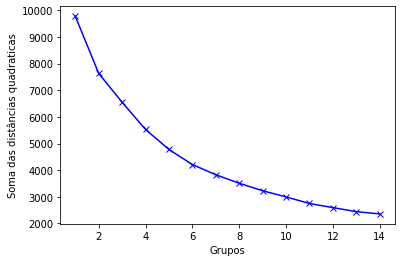

In [19]:
## Define as colunas a serem utilizadas
df_sep = df_covid_ivc_inter[['Mortalidade', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']]

X = StandardScaler().fit_transform(df_sep)
## Para saber qual a melhor quantidade de grupos, utilizamos a técnica de calcular a soma quadratica das distâncias.
## Dividimos de 1 até 15 grupos, calculamos o erro quadratico de cada e depois plotamos o gráfico
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)
py.plot(K, sum_of_squared_distances, 'bx-')
py.xlabel('Grupos')
py.ylabel('Soma das distâncias quadraticas')
py.show()

Observando o gráfico acimo, podemos perceber que 4 foi uma quantidade que muda bastante a inclinação.
Portanto, utilizare-mos 4 grupos para realizar a divisão.

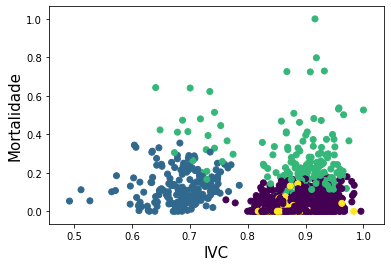

In [20]:
## Realizamos o K-means
modelo = KMeans(n_clusters=4, random_state=42)
rotulos = modelo.fit_predict(df_sep)
## Plotamos um gráfico levando em conta 2 dos 5 fatores utilizados.
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(df_sep['IVC'], df_sep['Mortalidade'], c=rotulos)

Adiciona essa classificação no dataset

In [21]:
df_covid_ivc_inter['classificacao'] = rotulos
df_1 = df_covid_ivc_inter[df_covid_ivc_inter['classificacao'] == 0]
df_1

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL,classificacao
0,PA,Alenquer,1500404,0.822484,-0.064845,0.002622,0.002720,150040,156,ALENQUER,0.004676,0.123261,4243,0.346571,0
2,PA,Ananindeua,1500800,0.814742,-0.025630,0.088264,0.041768,150080,160,ANANINDEUA,0.041941,0.081536,30539,0.278132,0
3,PA,Anapu,1500859,0.854498,-0.057117,0.000000,0.000000,150085,161,ANAPU,0.001825,0.134275,1053,0.220336,0
4,PA,Augusto Corrêa,1500909,0.828440,-0.065619,0.002323,0.002410,150090,162,AUGUSTO CORRÊA,0.003599,0.067571,2889,0.306651,0
5,PA,Aurora do Pará,1500958,0.843240,-0.063775,0.000599,0.000621,150095,163,AURORA DO PARÁ,0.002359,0.042421,1820,0.294708,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,SE,Capela,2801306,0.865595,-0.026329,0.000668,0.000693,280130,1761,CAPELA,0.002733,0.000000,2967,0.414608,0
1947,RO,Buritis,1100452,0.898113,-0.026617,0.009471,-0.021868,110045,27,BURITIS,0.002878,0.037095,1967,0.261100,0
1950,RO,Jaru,1100114,0.890734,-0.068036,0.029817,-0.047231,110011,10,JARU,0.004621,0.085282,4252,0.351454,0
1952,RO,Ouro Preto do Oeste,1100155,0.886905,-0.004887,0.006948,0.007209,110015,14,OURO PRETO DO OESTE,0.003370,0.117491,3367,0.381596,0


 ### Primeiramente vamos identificar os outliers considerando todos os dados do dataset

Para a identificação de outliers utilizaremos o algoritmo Local Outilier Factor, que mede o desvio local da densidade de uma determinada amostra em relação a seus vizinhos. A pontuação da anomalia depende de quão isolado o objeto está em relação à vizinhança.

In [22]:
chosen_columns = ['Mortalidade', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']
#chosen_columns = ['Mortalidade', 'IVC']

lof = LocalOutlierFactor(n_neighbors=20)
Y_lof = lof.fit_predict(df_covid_ivc_inter[chosen_columns])
outliers = Y_lof == -1
outlier_values = df_covid_ivc_inter.iloc[outliers]

Para saber o número de outliers encontrado no dataset:

In [23]:
outlier_values['Nome do município'].unique().shape[0]

85

Após plotarmos o gráfico podemos notar os outliers (em cor roxa). 

Note que a visualização não é clara pois estamos observando um conjunto de dados de 4 dimensões em um gráfico de apenas duas. 

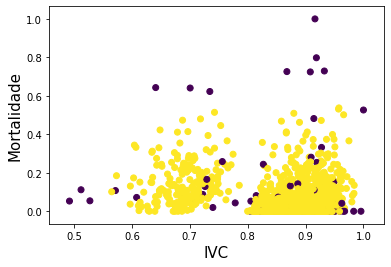

In [24]:
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(df_sep['IVC'], df_sep['Mortalidade'], c=Y_lof)

Agora fazendo a mesma análise, porém separando os dados pela classificação gerada pelo algoritmo K-Means.

Depois de identificados os outliers, verificamos se ele se trata de um outlier negativo ou positivo (pois isso afeta a maneira como ele será usado no cálculo final).
Para tal, verificamos se ele é maior ou menor que a média de todo o conjunto. Se for maior é positivo, do contrário é negativo. 

O resultado final será uma coluna que pode assumir os seguintes valores:
- 0: não é outlier
- -1: é outlier negativo
- 1 é outlier positivo

In [25]:
def outlier_type(is_out, is_greater):
    if(is_out == 1):
        return 0
    if(is_greater):
        return 1
    return -1

In [26]:
def classify_outlier(df):
    
    mean = df['Mortalidade'].mean()
    df['eh_pos_neg'] = df['Mortalidade'].apply(lambda x: x >= mean)
    df['tipo_outlier'] = df.apply(lambda x: outlier_type(x['eh_outlier'], x['eh_pos_neg']), axis=1)
    df.drop(['eh_outlier', 'eh_pos_neg'], axis=1, inplace=True)

Primeiramente identificamos os outliers do grupo número 0.

In [27]:
# O procedimento descrito aqui é feito em todas as outras classes

# Escolhe todos os dados pertencentes ao grupo 0 e as colunas para o cálculo
class_0 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 0, 
                                 chosen_columns]

#Instancia o Local Outlier Factor com 80 vizinhos
lof = LocalOutlierFactor(n_neighbors=80)

#Treina o modelo para obter os outliers (-1 é outlier 1 é inliner)
Y_lof = lof.fit_predict(class_0)

# Adiciona o dado obtido na tabela de dados
class_0['eh_outlier'] = Y_lof
classify_outlier(class_0)

Plotamos o gráfico para permitir observar a distribuição dos outliers

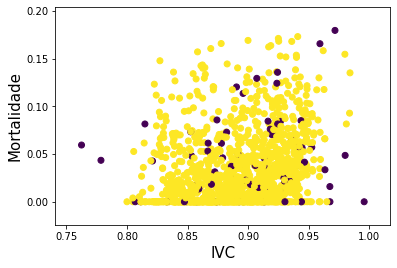

In [28]:
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_0['IVC'], class_0['Mortalidade'], c=Y_lof)

Agora para o grupo número 1

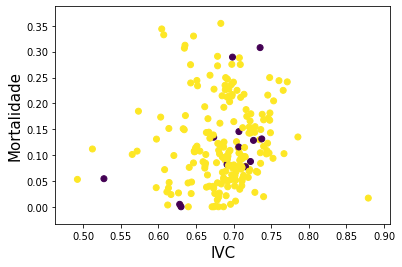

In [29]:
class_1 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 1, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_1)

class_1['eh_outlier'] = Y_lof
classify_outlier(class_1)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_1['IVC'], class_1['Mortalidade'], c=Y_lof)

Fazemos o memso para o grupo 2:

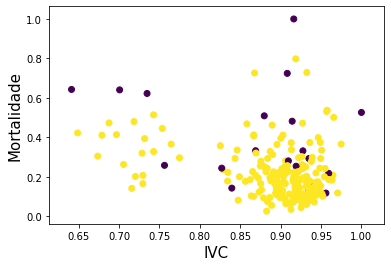

In [30]:
class_2 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 2, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_2)

class_2['eh_outlier'] = Y_lof
classify_outlier(class_2)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_2['IVC'], class_2['Mortalidade'], c=Y_lof)

E para o grupo 3:

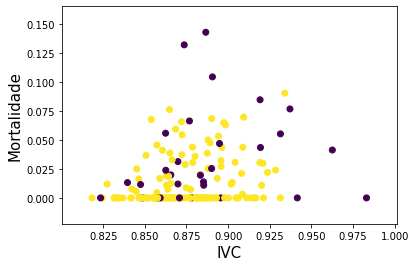

In [31]:
class_3 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 3, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_3)

class_3['eh_outlier'] = Y_lof
classify_outlier(class_3)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_3['IVC'], class_3['Mortalidade'], c=Y_lof)

Feito isso adicionamos o resultado no conjunto de dados com todas as colunas

In [32]:
df = pd.concat([class_0, class_1, class_2, class_3])
df = df[['tipo_outlier']]

In [33]:
df = pd.concat([df_covid_ivc_inter, df], axis=1)

### A ultima parte consiste em calcular o indice de vulnerabilidade geral das cidades

In [34]:
## Criamos uma função que ajusta o indice de mortalidade de acordo com o grupo que ele se encontra, e se o mesmo é um outlier positivo ou negativo
def valuesGroup(group, outlier):
    ## Grupo com menor risco 
    if group == 0:
        if outlier == 1:
            return 0.80
        elif outlier == -1:
            return 0.70
        return 0.75
    
    ##Grupo de maior risco
    if group == 2:
        if outlier == 1:
            return 1.30
        elif outlier == -1:
            return 1.20
        return 1.25
    
    ## Segundo grupo com menor risco
    if group == 3:
        if outlier == 1:
            return 1.0
        elif outlier == -1:
            return 0.90
        return 0.95
    
    ## Grupo de segundo maior risco
    if group == 1:
        if outlier == 1:
            return 1.15
        elif outlier == -1:
            return 1.05
        return 1.10
        

In [35]:
df

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL,classificacao,tipo_outlier
0,PA,Alenquer,1500404,0.822484,-0.064845,0.002622,0.002720,150040,156,ALENQUER,0.004676,0.123261,4243,0.346571,0,0
1,PA,Altamira,1500602,0.678725,-0.022813,0.180609,0.046367,150060,158,ALTAMIRA,0.008804,0.411146,6534,0.283488,2,0
2,PA,Ananindeua,1500800,0.814742,-0.025630,0.088264,0.041768,150080,160,ANANINDEUA,0.041941,0.081536,30539,0.278132,0,1
3,PA,Anapu,1500859,0.854498,-0.057117,0.000000,0.000000,150085,161,ANAPU,0.001825,0.134275,1053,0.220336,0,0
4,PA,Augusto Corrêa,1500909,0.828440,-0.065619,0.002323,0.002410,150090,162,AUGUSTO CORRÊA,0.003599,0.067571,2889,0.306651,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,RO,Ji-Paraná,1100122,0.910608,-0.058079,0.249287,-0.011513,110012,11,JI-PARANÁ,0.010362,0.113325,8866,0.326823,2,0
1952,RO,Ouro Preto do Oeste,1100155,0.886905,-0.004887,0.006948,0.007209,110015,14,OURO PRETO DO OESTE,0.003370,0.117491,3367,0.381596,0,0
1953,RO,Porto Velho,1100205,0.742678,-0.078289,0.104282,-0.008174,110020,16,PORTO VELHO,0.038079,0.514303,24144,0.242187,2,0
1954,RO,São Francisco do Guaporé,1101492,0.881206,-0.051562,0.005496,-0.008384,110149,45,SÃO FRANCISCO DO GUAPORÉ,0.001425,0.026672,1038,0.278259,0,0


## Parte Final: Calculando o Indice de Vulnerabilidade Final

Para a crianção desse indice, utilizaremos os resultados encontrados acima
A fórmula para o calculo é:
VG = (Taxa de mortalidade * 0.3 + IVC * 0.1 - Hospitais * 0.1 + Ocupação1 * 0.05 + ocupação2*0.05 + População Idosa * 0.1 + População total * 0.25) * Valor Resultante do Grupo e outlier

#### OBS: Os sinais na fórmula podem ser invertidos para que pese positiva ou negativamente no cálculo. Como os hospitais são todos valores negativos, ele irá somar normalmente, enquanto que o IVC terá sinal negativo,

In [36]:
## Criamos a coluna para armezenar a vulnerabilidade
df['Vulnerabilidade Geral'] = 0

## Adicionamos a mortalidade, IVC, hospitais, ocupacao, populacao idosa
df['Vulnerabilidade Geral'] = df['Mortalidade'] * 0.3 - df['IVC'] * 0.1 - df['hospitais']*0.1 + df['ocupacao1']*0.05 + df['ocupacao2']*0.05 + df['POPULACAO IDOSA PERCENTUAL']*0.1


##Populacao total
df['Vulnerabilidade Geral'] = df['Vulnerabilidade Geral'] + df['População total']*0.25

## Divisao pelos grupos e pelos outliers
df['Vulnerabilidade Geral'] = df['Vulnerabilidade Geral']*df.apply(lambda x: valuesGroup(x['classificacao'], x['tipo_outlier']), axis=1)


df = df.sort_values('Vulnerabilidade Geral')

Realizando uma comparação com o IVC

C:\Users\luank\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186A2FF7188>,
      dtype=object)

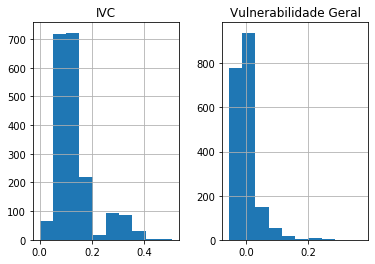

In [37]:
df2 = df[['UF', 'Nome do município', 'Vulnerabilidade Geral', 'IVC']]
a = df2[['Vulnerabilidade Geral', 'IVC']]
a['IVC'] = 1 - a['IVC']
a.hist()

In [38]:
a['Vulnerabilidade Geral'].corr(a['IVC'])

0.359346605218874

In [39]:
dfa = df[['UF', 'Nome do município', 'Vulnerabilidade Geral']]
dfa = dfa.sort_values('Vulnerabilidade Geral', ascending=False)
dfa.head(10)

,UF,Nome do município,Vulnerabilidade Geral
1218,SP,Pariquera-Açu,0.373778
1294,SP,São Paulo,0.327218
239,CE,Sobral,0.264516
552,PR,Campo Largo,0.247454
674,RJ,Rio de Janeiro,0.244462
551,PR,Campina Grande do Sul,0.240822
1342,TO,Augustinópolis,0.233426
395,PB,Santa Rita,0.233328
270,ES,Serra,0.230632
476,PE,Recife,0.210168


In [40]:
dfa.tail(10)

,UF,Nome do município,Vulnerabilidade Geral
1891,GO,Santo Antônio do Descoberto,-0.046995
1713,MS,Nova Alvorada do Sul,-0.047042
1721,MS,Ribas do Rio Pardo,-0.047643
33,PA,Santana do Araguaia,-0.047982
311,MT,Alto Taquari,-0.048268
1243,SP,Porto Feliz,-0.048816
1666,MS,Água Clara,-0.049226
349,MT,Nova Maringá,-0.050097
1778,GO,Chapadão do Céu,-0.052903
433,PE,Fernando de Noronha,-0.056527
